# Adversarial Autoencoder
_(Requires Python 3, PyTorch 1.0.1, TorchVision 0.2.2)_

**Reference**: _A.Makhzani et al.,_ [Adversarial Autoencoders](https://arxiv.org/abs/1511.05644)

### Libraries
Import torch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.utils.data as Data

we'll also need numpy and matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Model
The Adversarial Autoencoder exploits the same trick of the Variational AutoEncoder: enforcing a prior distribution on the latent space. In this case, however, the distribution is enforced using an adversarial network named _discriminator_. The role of the discriminator is to distringuish the samples generated by the encoder (_fake_ samples) from actual samples of the imposed distribution (_true_ samples).

The learning proceeds in a two-player-game fashion:
- **Discriminator**: Aims to distinguish the samples generated by the encoder from samples taken from the objective distribution.
- **Autoencoder**: Maximizes the similarity between the input and the output samples. At the same time, tries to fool the discriminator by mimicking the objective distribution in the latent space.

### Encoder

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, lat_dim, activations=func.relu):
        super(Encoder, self).__init__()
        
        # Parse input arguments
        if type(hidden_dims) == int:
            hidden_dims = [hidden_dims,]

        if type(activations) == list:
            if len(activations) != len(hidden_dims):
                raise ValueError('activations and hidden_dims must have the same dimensions')
        else:
            activations = [activations]*len(hidden_dims)

        # Store arguments
        self.hidden_dims = np.array(hidden_dims)
        self.activations = activations
        
        # Create layers
        self.layers = nn.ModuleList()
        prev_d = input_dim
        for d in hidden_dims:
            self.layers.append(nn.Linear(prev_d, d))
            prev_d = d
            
        # Latent layer
        self.layers.append(nn.Linear(prev_d, lat_dim))
        self.activations.append(lambda x: x)
        
    def forward(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        
        return x

### Decoder

In [4]:
class Decoder(nn.Module):
    
    def __init__(self, lat_dim, hidden_dims, output_dim, activations=func.relu):
        super(Decoder, self).__init__()
        
        # Parse input arguments
        if type(hidden_dims) == int:
            hidden_dims = [hidden_dims,]
        
        if type(activations) == list:
            if len(activations) != len(hidden_dims):
                raise ValueError('activations and hidden_dims must have the same dimensions')
        else:
            activations = [activations]*len(hidden_dims)
            
        # Store arguments
        self.hidden_dims = np.array(hidden_dims)
        self.activations = activations
        activations.append(torch.sigmoid)
        
        # Create layers
        self.layers = nn.ModuleList()
        prev_d = lat_dim
        for d in self.hidden_dims:
            self.layers.append(nn.Linear(prev_d, d))
            prev_d = d
            
        # Output layer
        self.layers.append(nn.Linear(prev_d, output_dim))

            
    def forward(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        
        return x

### Discriminator

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self, lat_dim, hidden_dims, activations=func.relu):
        super(Discriminator, self).__init__()
        
        # Parse input arguments
        if type(hidden_dims) == int:
            hidden_dims = [hidden_dims,]
        
        if type(activations) == list:
            if len(activations) != len(hidden_dims):
                raise ValueError('activations and hidden_dims must have the same dimensions')
        else:
            activations = [activations]*len(hidden_dims)
            
        # Store arguments
        self.hidden_dims = np.array(hidden_dims)
        self.activations = activations
        activations.append(torch.sigmoid)
        
        # Create layers
        self.layers = nn.ModuleList()
        prev_d = lat_dim
        for d in self.hidden_dims:
            self.layers.append(nn.Linear(prev_d, d))
            prev_d = d
            
        # Output layer
        self.layers.append(nn.Linear(prev_d, 1))
    
    def forward(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        
        return x

### Adversarial Autoencoder

In [6]:
class AdversarialAutoencoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, lat_dim, activation=func.relu):
        super(AdversarialAutoencoder, self).__init__()
        
        # Create encoder
        self.encoder = Encoder(input_dim, hidden_dims, lat_dim, activation)
        
        # Create decoder
        self.decoder = Decoder(lat_dim, np.flip(np.array(hidden_dims)), input_dim, activation)
        
        # Create discriminator
        self.discrim = Discriminator(lat_dim, np.flip(np.array(hidden_dims)), activation)
        
        # Set status
        self.status = 'train'
        
    def set_status(self, s):
        self.status = s
        
    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        if self.status == 'train':
            d = self.discrim(x)
            return y, d
        else:
            return y

## Training example

### Training Data
Let's train the denoising autoencoder on the MNIST dataset.

In [7]:
import torchvision
train = torchvision.datasets.MNIST('./', train=True, download=True, transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.MNIST('./', train=False, download=True, transform=torchvision.transforms.ToTensor())

### Instantiate Autoencoder

In [8]:
input_dim  = 28*28
layers     = [200,100,30]
latent_dim = 2

aae = AdversarialAutoencoder(input_dim, layers, latent_dim)

In [9]:
aae

AdversarialAutoencoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): Linear(in_features=200, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=30, bias=True)
      (3): Linear(in_features=30, out_features=2, bias=True)
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=30, bias=True)
      (1): Linear(in_features=30, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=200, bias=True)
      (3): Linear(in_features=200, out_features=784, bias=True)
    )
  )
  (discrim): Discriminator(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=30, bias=True)
      (1): Linear(in_features=30, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=200, bias=True)
      (3): Linear(in_features=200, out_features=1, bias=True)
    )
  )
)

### Optimizer

In [10]:
aae_optimizer = torch.optim.Adam(list(aae.encoder.parameters()) + list(aae.decoder.parameters()), lr=0.001)
fool_optimizer = torch.optim.Adam(aae.encoder.parameters(), lr=0.001)
discrim_optimizer = torch.optim.Adam(aae.discrim.parameters(), lr=0.001)

### Training loop

<IPython.core.display.Javascript object>


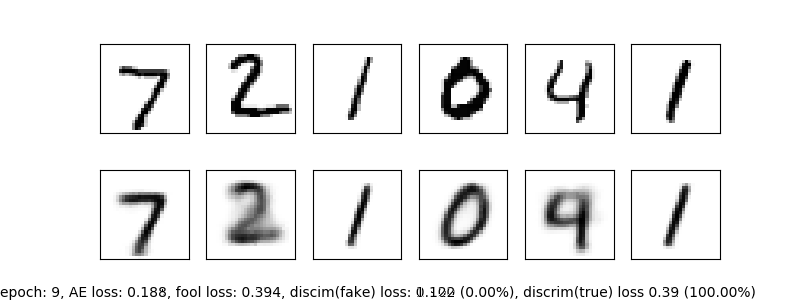

KeyboardInterrupt: 

In [11]:
%matplotlib notebook

n_test_img = 6
epochs     = 15
batch_size = 100

# Reshape data
train_samples = train.data.view(-1, 28*28).type(torch.float32)/255.0
test_samples  = test.data.view(-1,28*28).type(torch.float32)/255.0

# Lists to store training losses
train_loss = []
test_loss  = []

# Set model to training mode
aae.train()

# Plot test input images
test_imgs = test.data[0:n_test_img,:].type(torch.float32).view(-1,28*28)/255.0
f, a = plt.subplots(2, n_test_img, figsize=(8, 3))
for i in range(n_test_img):
    a[0][i].imshow(255-np.reshape(test_imgs.data.numpy()[i], (28,28)), cmap='gray')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
    
loss_text = f.text(0, 0.01, "epoch: 0, loss: 0")

# Discriminator targets
target_true = torch.ones(batch_size,1)
target_fake = torch.zeros(batch_size,1)

# Data iterator
train_batches = Data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, drop_last=True)

for e in np.arange(epochs):
    batch_loss = 0
    for batch_no, (batch, batch_labels) in enumerate(train_batches):
        # Input and target data (flatten)
        b_in = batch.view(-1, 28*28)
        target_autoenc = batch.view(-1, 28*28)
        
        # Forward pass of the data through the network
        aae.set_status('train')
        y, d = aae(b_in)
        
        # Compute the AAE Losses
        autoenc_loss = func.binary_cross_entropy(y, target_autoenc)
        discrim_fake_loss = func.binary_cross_entropy(d, target_fake)
        fool_loss    = func.binary_cross_entropy(d, target_true)
        
        batch_loss += autoenc_loss
        
        # Discriminator accuracy
        discrim_fake_acc = np.sum((d < 0.5).data.numpy()) / batch_size
        
        ## Autoencoding loss
        # Compute gradients
        aae_optimizer.zero_grad()
        autoenc_loss.backward(retain_graph=True)
        # Update encoder-decoder parameters
        aae_optimizer.step()
        
        ## Discriminator loss
        # Compute gradients
        aae_optimizer.zero_grad()
        discrim_fake_loss.backward(retain_graph=True)
        # Update discriminator parameters
        discrim_optimizer.step()
        
        ## Fool loss
        # Compute gradients
        aae_optimizer.zero_grad()
        fool_loss.backward()
        # Update encoder parameters
        fool_optimizer.step()
        
        ## Train Discriminator
        # Forward samples from prior distribution
        d = aae.discrim(torch.randn(batch_size, latent_dim))
        
        # Compute loss
        discrim_true_loss = func.binary_cross_entropy(d, target_true)
        
        # Compute accuracy
        discrim_true_acc = np.sum((d > 0.5).data.numpy()) / batch_size
        
        ## Discriminator loss
        # Compute gradients
        aae_optimizer.zero_grad()
        discrim_true_loss.backward()
        # Update Discriminator parameters
        discrim_optimizer.step()
        
        # Test images
        if batch_no % 50 == 0:
            aae.set_status('test')
            test_out = aae(test_imgs)
            for i in range(n_test_img):
                a[1][i].imshow(1.0-np.reshape(test_out.data.numpy()[i], (28,28)), cmap='gray')
                a[1][i].set_xticks(())
                a[1][i].set_yticks(())
            loss_text.set_text("epoch: {}, AE loss: {:.3f}, fool loss: {:.3f}, discim(fake) loss: {:.3f} ({:.2f}%), discrim(true) loss {:.2f} ({:.2f}%)".format(e+1, autoenc_loss, fool_loss, discrim_fake_loss, discrim_fake_acc*100, discrim_true_loss, discrim_true_acc*100))
            f.canvas.draw()

    # End of epoch, compute train & test loss
    aae.set_status('test')
    train_loss.append(batch_loss/batch_no)
    test_loss.append(func.binary_cross_entropy(aae(test_samples), test_samples).data.numpy())


### Loss plots

In [ ]:
train_loss

In [ ]:
tloss = [float(x.data.numpy()) for x in test_loss]
tloss

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.plot(tloss)
plt.legend(['train', 'test'])

## Results
### Loss on test dataset
We can easily compute the Loss by evaluating the loss function on the output data:

#### Train Loss

In [ ]:
print("Train loss: {}".format(train_loss[-1]))

#### Test Loss

In [ ]:
print("Test loss: {}".format(test_loss[-1]))

### Latent space
The projections of the test images in the latent space after training look like this:

In [ ]:
test_d = aae.encoder(test_samples)
plt.figure(figsize=(10,7))
plt.scatter(test_d.data.numpy()[:,0], test_d.data.numpy()[:,1], c=test.targets.numpy(), s=1.7)

In [ ]:
test_d = aae.encoder(train_samples)
plt.figure(figsize=(10,7))
plt.scatter(test_d.data.numpy()[:,0], test_d.data.numpy()[:,1], c=train.targets.numpy(), s=1.7)